<a href="https://colab.research.google.com/github/JuanCappelletti/Consteel_H06/blob/main/torre_comportanmiento%20energetico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:

#@title Ejecutar librerias { run: "auto", display-mode: "form" }
from matplotlib.font_manager import json_dump
from numpy.matrixlib.defmatrix import N
from operator import truediv
import numpy as np
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.graph_objects as go
from IPython.display import Image
import math
import matplotlib.patches as mpatches
# temperatua de bulbo humedo
def calcular_temperatura_bulbo_humedo(T, RH):
    # Cálculos intermedios
    part1 = 0.151977 * math.sqrt(RH + 8.313659)
    part2 = math.atan(T + RH)
    part3 = math.atan(RH -1.676331)
    part4 = 0.00391838 *(RH**(3/2)) * math.atan(0.023101 * RH)
    # Cálculo de la temperatura de bulbo húmedo (Tw)
    Tw = round((T * math.atan (part1) + part2 - part3 + part4 - 4.686035),2)
    return Tw

# punto de Rocio
def calcular_punto_rocio(T, RH):
    alpha = math.log((RH/100),math.e) + (17.625 * T) / (243.04 + T)
    Ts = round((243.04 * alpha) / (17.625 - alpha),2)
    return Ts



# ***Process flow diagram***

---
## ***Referencias:***
- Supply Flow (Water to Steel Mill)= QS
- Total Return flow ( Water from Steel Mill)= QRT
- Return Flow (chilled water, represent approximately 70% of the return flow total water ) = QR
- By-pass Flow (proportional non chilled water, represent approximately 30% of the return flow total water )= QBY
- Make-up Flow (water replenishment) = QM
- Overflow Flow = QO
- Temperature return Water (measured in pipe)= tr
- Temperature pool Water (equilibrium temperature) = tp
- Temperature enviroment = te


Mounted at /content/drive


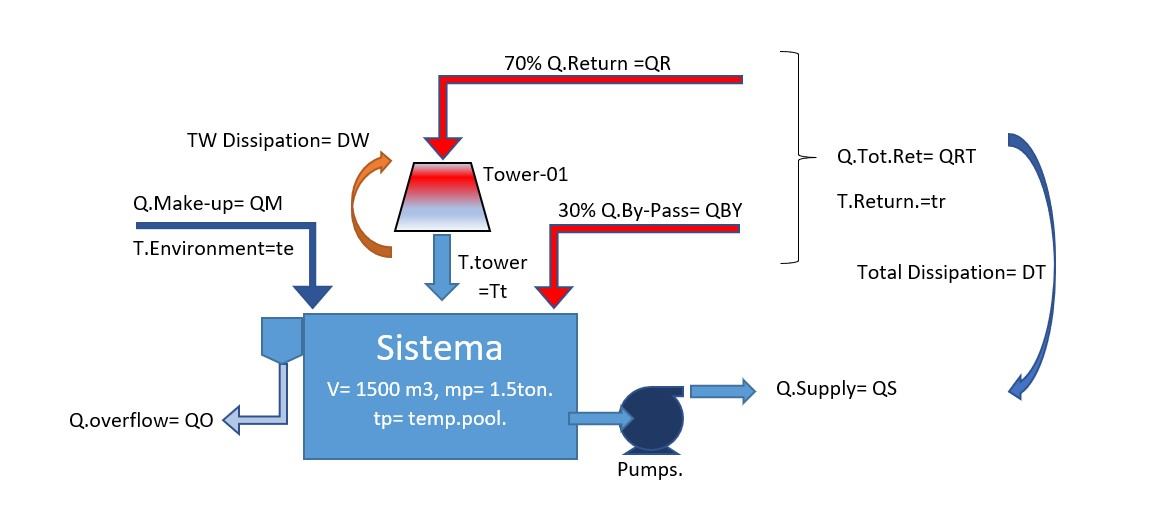

In [ ]:
# @title
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
Image('/content/drive/MyDrive/ESQUEMATORRE.jpg',width=1000)


# ***Muestra de referencia:***

---
*La muestra analizada corresponde a la medición obtenida de nivel 2 de instrumentación existente en campo:*  

*   *Temperatura de pileta (TIR-249/TIR-250)*
*   *Temperatura de agua de retora a torre (TT-905)*
*   *Caudal de envio agua hacia Aceria suma(TOT= FIR-748 + FT903 + FT901)*
*   *Caudal de retorno a torre (TOT= FT-904 + FT-764)*
*   *Caudal de make-up (FIR-772)*

*En rango de muestro fue entre el 12/02/2023, 5 AM hasta el 13/02/2023 5 AM, siendo estas 24 hrs un periodo con condiciones ambientes elevadas.*

*Los datos climáticos regionales fueron extraídos del registro diario del Servicio meteorológico nacional, centro de observación mas cerca a Campana, Aeropuerto de San Fernando.*

*La curva relativa a la temperatura de bulbo húmedo se calcula en base a una simplificación empírica basada en la ecuación de Stull.*

*Ecuación para la temperatura de bulbo húmedo como una función de la temperatura del aire y la humedad relativa a la presión estándar al nivel del mar. Es una expresión empírica simplificada utilizando programación de expresión genética (análisis computacional redes neuronales).*

*La formulación es válida para humedades relativas entre el 5% y el 99% y para temperaturas del aire entre -22.08 y 50.8 grados Celsius, excepto en situaciones que tienen tanto baja humedad como baja temperatura. Dentro del rango válido, los errores en la temperatura de bulbo húmedo oscilan entre -2.18 y 10.65 grados Celsius, con un error absoluto promedio de menos de 0.38 grados Celsius.*

*Para obtener la curva del punto de roció, se utilizó una aproximación de la fórmula de Magnus-Tetens (Lawrence 2005), que nos permite obtener resultados precisos (con una incertidumbre de 0.35 °C) para temperaturas que van desde -45 °C hasta 60 °C.*

In [23]:
from prompt_toolkit.layout.dimension import D
Url = "https://raw.githubusercontent.com/JuanCappelletti/Consteel_H06/main/TOMA%20TEMP.csv" #@param {type:"string"}
tab = False # @param {type:"boolean"}
datos = pd.read_csv(Url,sep=",",decimal=".")
df=pd.DataFrame(datos)
dfx=df.copy()
if tab:
   print(dfx)


In [24]:
tab = True # @param {type:"boolean"}
dfa = df.copy()
dfa['TW'] = 0.0  # Temperatura de bulbo Húmedo
dfa['TS'] = 0.0  # Temperatura de Rocio
dfa['DISIPTOTAL'] = 0.0  # Inicializa la columna como float
dfa['POTENTRADA'] = 0.0  # Inicializa la columna como float
dfa['POTMAKEUP'] = 0.0  # Inicializa la columna como float

for i in range(len(dfa)):
    valor = dfa['TDIA'][i]
    valor1 = dfa['HR'][i]
    AUX = calcular_temperatura_bulbo_humedo(valor, valor1)
    dfa.at[i, 'TW'] = AUX  # Asigna el valor calculado a la columna 'TW'

for i in range(len(dfa)):
    valor = dfa['TDIA'][i]
    valor1 = dfa['HR'][i]
    AUX = calcular_punto_rocio(valor, valor1)
    dfa.at[i, 'TS'] = AUX  # Asigna el valor calculado a la columna 'TW'

for i in range(len(dfa)):
    valor = dfa['QENTRADA'][i]
    AUX = round(((valor / 3600) * 1000 * 4184 * (dfa['TRETORNO'][i] - dfa['TTORRE'][i])) / 1000000, 2)
    dfa.at[i, 'DISIPTOTAL'] = AUX  # Asigna el valor calculado a la columna 'DISIPTOTAL'

for i in range(len(dfa)):
   valor = dfa['QENTRADA'][i]
   AUX = round(((valor / 3600) * 1000 * 4184 * ((dfa['TRETORNO'][i]*0.03) )-dfa['TTORRE'][i]) / 1000000, 2)
   dfa.at[i, 'POTENTRADA'] = AUX

for i in range(len(dfa)):
    valor = dfa['REPOSICION'][i]
    AUX = round(((valor / 3600) * 1000 * 4184 * ((dfa['TTORRE'][i]*0.03) )-dfa['TDIA'][i]) / 1000000, 2)
    dfa.at[i, 'POTMAKEUP'] = AUX
if tab:
   print(dfa)

           date       time  QENTRADA  REPOSICION  QRETORNO  TTORRE  TRETORNO  \
0     12/2/2023   05:00:00     11240         280     11510    34.9      39.6   
1     12/2/2023   05:01:00     11480         270     11590    35.1      39.6   
2     12/2/2023   05:02:00     11350         240     11620    35.0      39.7   
3     12/2/2023   05:03:00     11370         280     11730    35.0      39.6   
4     12/2/2023   05:04:00     11270         285     11670    34.9      39.5   
...         ...        ...       ...         ...       ...     ...       ...   
1436  13/2/2319   04:56:00     11290         263     11450    37.9      42.1   
1437  13/2/2320   04:57:00     11220         259     11650    37.8      42.1   
1438  13/2/2321   04:58:00     11240         268     11630    37.6      42.1   
1439  13/2/2322   04:59:00     11300         304     11680    37.8      42.0   
1440  13/2/2323   05:00:00     11310         289     11590    37.4      41.7   

      TDIA  HR     PNM     TW     TS  D

Cantidad de items sampleados:  1441
Fecha de la muestra:  12/2/2023 -  05:00:00 al 13/2/2323 -  05:00:00
Muestreo cada 1 minuto


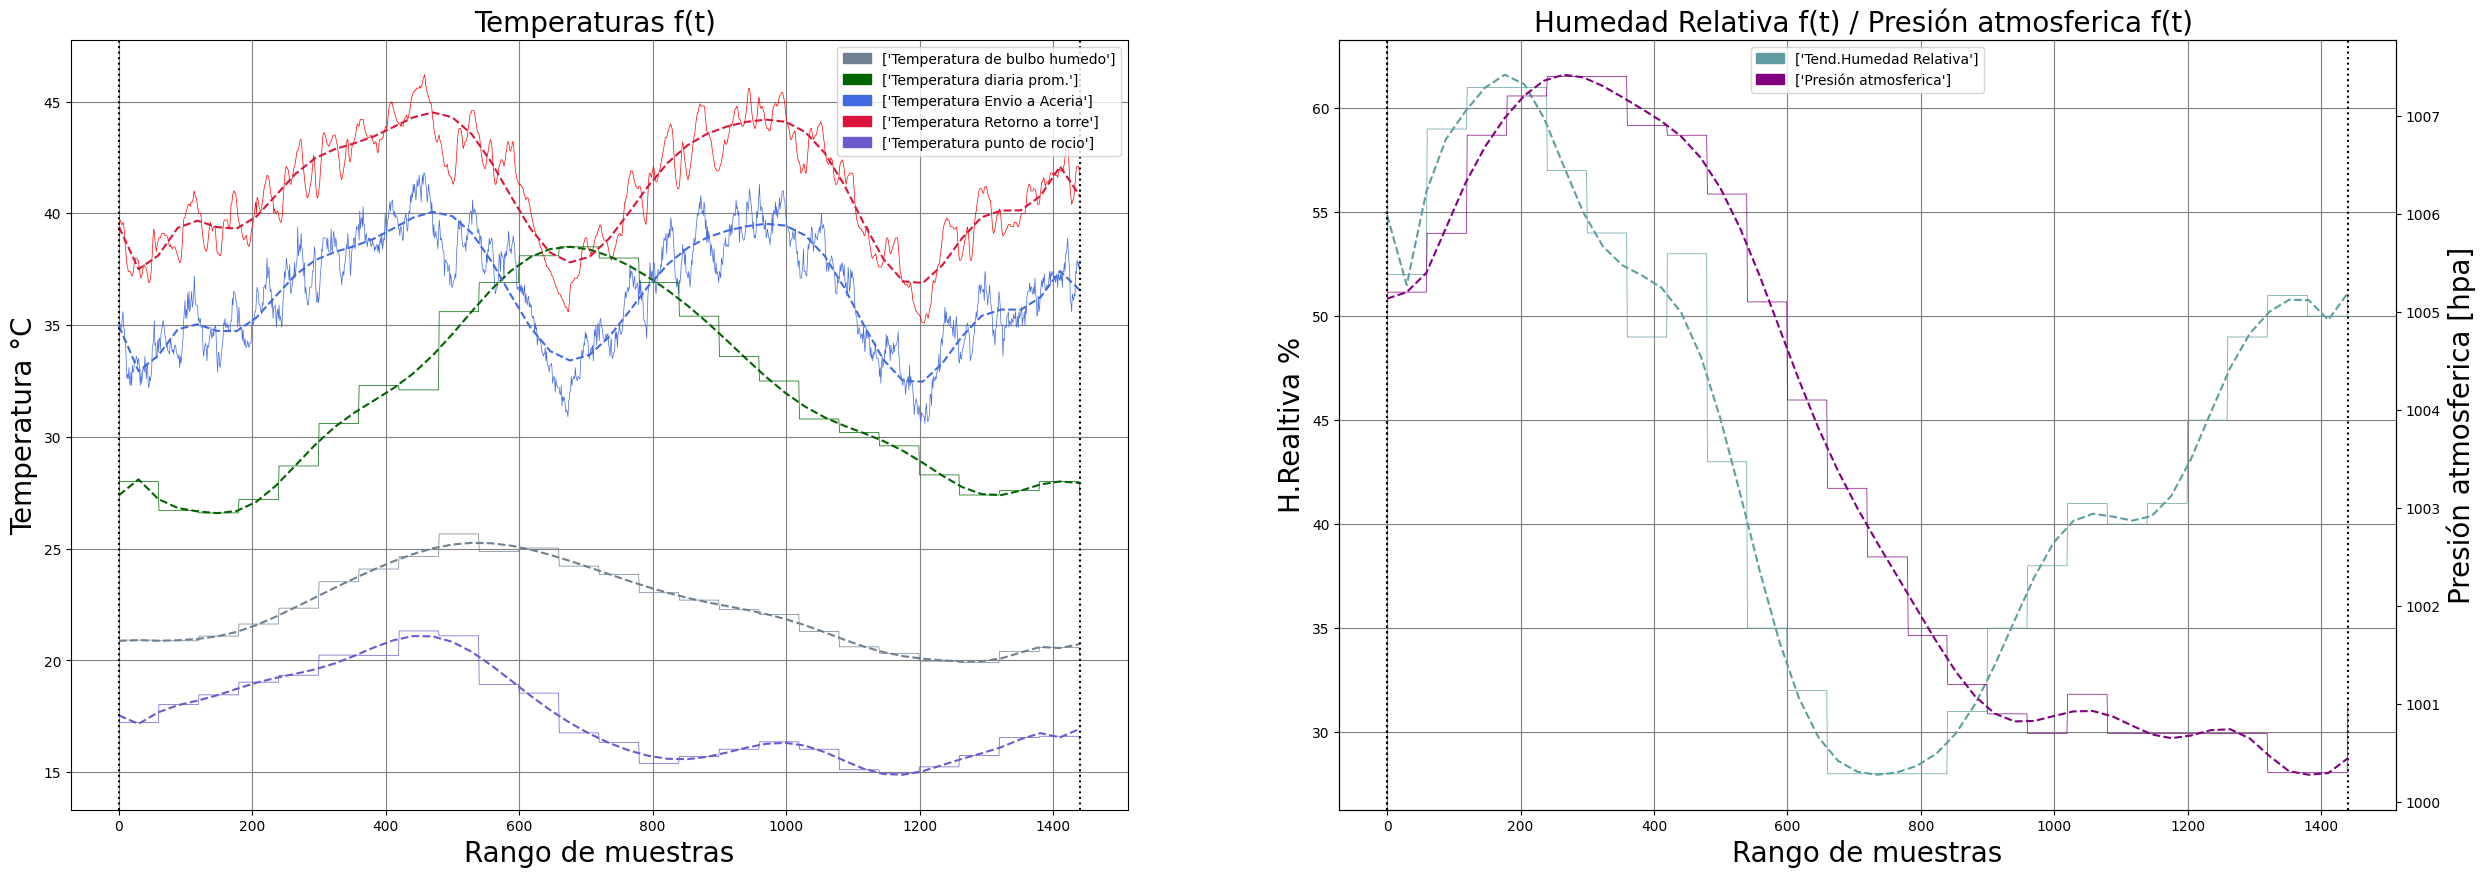

In [79]:
from sys import builtin_module_names
from matplotlib.ticker import AutoLocator
from io import DEFAULT_BUFFER_SIZE
from matplotlib.ticker import MaxNLocator

text='H.Realtiva %'
text1='Presión atmosferica [hpa]'
text2='Rango de muestras'
text3='Temperatura °C'

print('Cantidad de items sampleados: ', len(dfx.index))
print('Fecha de la muestra: ',dfx.date[0],'-',dfx.time[0], 'al',dfx.date[(len(dfx.index)-1)],'-',dfx.time[(len(dfx.index)-1)])
print('Muestreo cada 1 minuto')

# Grado del polinomio de tendencia (ajusta según tus necesidades)
grado_polinomio =17


# Ajustar el polinomio de tendencia a los datos
coefficients = np.polyfit( dfa.index,dfa['TDIA'], grado_polinomio)
coefficients1 = np.polyfit( dfa.index,dfa['TTORRE'], grado_polinomio)
coefficients2 = np.polyfit( dfa.index,dfa['TRETORNO'], grado_polinomio)
coefficients3 = np.polyfit( dfa.index,dfa['TW'], grado_polinomio)
coefficients4 = np.polyfit( dfa.index,dfa['TS'], grado_polinomio)

coefficients5 = np.polyfit( dfa.index,dfa['HR'], grado_polinomio)
coefficients6 = np.polyfit( dfa.index,dfa['PNM'], grado_polinomio)

polynomial = np.poly1d(coefficients)
polynomial1 = np.poly1d(coefficients1)
polynomial2 = np.poly1d(coefficients2)
polynomial3 = np.poly1d(coefficients3)
polynomial4 = np.poly1d(coefficients4)

polynomial5 = np.poly1d(coefficients5)
polynomial6 = np.poly1d(coefficients6)


# Crear valores x para la línea de tendencia
x_trendline = np.linspace(dfx.index.min(), dfx.index.max())

# Calcular valores y correspondientes para la línea de tendencia polinómica
y_trendline = polynomial(x_trendline)
y_trendline1 = polynomial1(x_trendline)
y_trendline2 = polynomial2(x_trendline)
y_trendline3 = polynomial3(x_trendline)
y_trendline4 = polynomial4(x_trendline)

y_trendline5 = polynomial5(x_trendline)
y_trendline6 = polynomial6(x_trendline)


# Grestion final del gradico .......
fig, (ax1,ax2)= plt.subplots(1,2 ,figsize=(30,10))
#Graficas directas
ax1.plot(dfa.index,dfa['TTORRE'],linewidth=0.5,color='royalblue')#label=f'Temp.Envio'
ax1.plot(dfa.index,dfa['TRETORNO'],linewidth=0.5,color='red')#,label=f'Temp.Retorno (TT-905)'
ax1.plot(dfa.index,dfa['TDIA'],linewidth=0.5,color='darkgreen')
ax1.plot(dfa.index,dfa['TW'],linewidth=0.5,color='slategray')
ax1.plot(dfa.index,dfa['TS'],linewidth=0.5,color='slateblue')


ax2.plot(dfa.index,dfa['HR'],linewidth=0.5,color='cadetblue')
twin_axes = ax2.twinx()
twin_axes.plot(dfa.index,dfa['PNM'],linewidth=0.5,color='purple')


#trend de tendencias
ax1.plot(x_trendline, y_trendline, color='darkgreen',linestyle='--')
ax1.plot(x_trendline, y_trendline1,color='royalblue',linestyle='--')
ax1.plot(x_trendline, y_trendline2,color='crimson',linestyle='--')
ax1.plot(x_trendline, y_trendline3, color='slategray',linestyle='--')
ax1.plot(x_trendline, y_trendline4,color='slateblue',linestyle='--')

green_patch= mpatches.Patch(color='darkgreen', label=['Temperatura diaria prom.'])
blue_patch= mpatches.Patch(color='royalblue', label=['Temperatura Envio a Aceria'])
red_patch= mpatches.Patch(color='crimson', label=['Temperatura Retorno a torre'])
gray_patch= mpatches.Patch(color='slategray', label=['Temperatura de bulbo humedo'])
slateblue_patch= mpatches.Patch(color='slateblue',label=['Temperatura punto de rocio'])

ax2.plot(x_trendline, y_trendline5, color='cadetblue',linestyle='--')
twin_axes.plot(x_trendline, y_trendline6, color='purple',linestyle='--')

cadet_patch = mpatches.Patch(color='cadetblue', label=['Tend.Humedad Relativa'])
cyan_patch = mpatches.Patch(color='purple', label=['Presión atmosferica'])

#lineas
ax1.axvline(dfa.index[0], color='black', linestyle='dotted', label='cappelleti')
ax2.axvline(dfa.index[0], color='black', linestyle='dotted', label='cappelleti')
ax2.axvline(dfa.index[0], color='black', linestyle='dotted', label='cappelleti')
ax1.axvline(dfa.index[-1], color='black', linestyle='dotted', label='cappelleti')
ax2.axvline(dfa.index[-1], color='black', linestyle='dotted', label='cappelleti')

#Etiquetas
ax1.set_title('Temperaturas f(t) ',fontsize=20)
ax2.set_title('Humedad Relativa f(t) / Presión atmosferica f(t) ',fontsize=20)
ax1.set_xlabel(text2,fontsize=20)
ax2.set_xlabel(text2,fontsize=20)
ax1.set_ylabel(text3,fontsize=20)
ax2.set_ylabel(text,fontsize=20)
twin_axes.set_ylabel(text1,fontsize=20)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))
ax2.xaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))
labels2 = ax1.get_xticklabels()
labels3= ax1.get_yticklabels()
plt.setp(labels3,fontsize=10, horizontalalignment='right')

ax1.axes.grid(True, which='major',color='grey',axis='both')
ax2.axes.grid(True, which='major',color='grey',axis='both')

ax1.legend(handles={green_patch,blue_patch,red_patch,gray_patch,slateblue_patch})
ax2.legend(handles={cadet_patch,cyan_patch})

ax2.autoscale_view()
# Mostrar el gráfico
plt.show()





           date       time  QENTRADA  REPOSICION  QRETORNO  TTORRE  TRETORNO  \
0     12/2/2023   05:00:00     11240         280     11510    34.9      39.6   
1     12/2/2023   05:01:00     11480         270     11590    35.1      39.6   
2     12/2/2023   05:02:00     11350         240     11620    35.0      39.7   
3     12/2/2023   05:03:00     11370         280     11730    35.0      39.6   
4     12/2/2023   05:04:00     11270         285     11670    34.9      39.5   
...         ...        ...       ...         ...       ...     ...       ...   
1436  13/2/2319   04:56:00     11290         263     11450    37.9      42.1   
1437  13/2/2320   04:57:00     11220         259     11650    37.8      42.1   
1438  13/2/2321   04:58:00     11240         268     11630    37.6      42.1   
1439  13/2/2322   04:59:00     11300         304     11680    37.8      42.0   
1440  13/2/2323   05:00:00     11310         289     11590    37.4      41.7   

      TDIA  DISIPTOTAL  POTENTRADA  POT

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


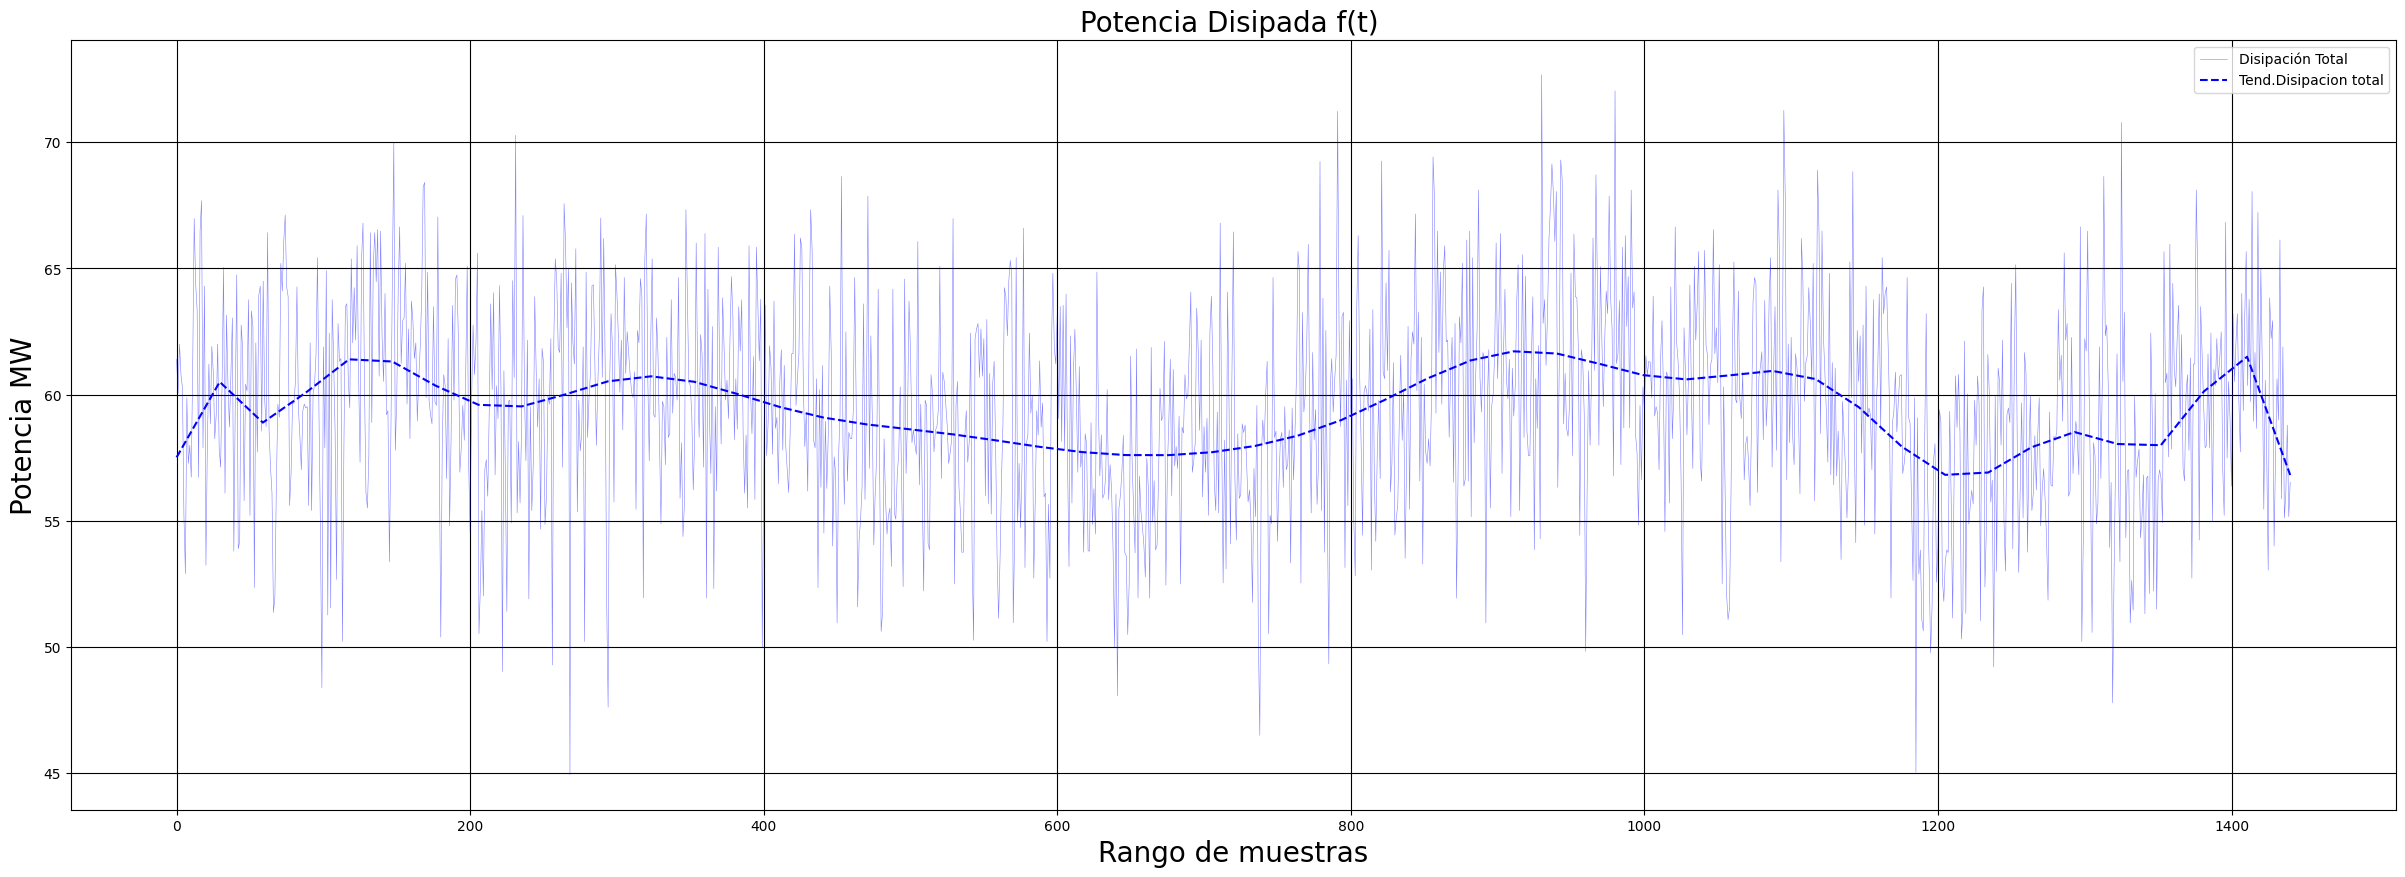

In [ ]:

# Grado del polinomio de tendencia (ajusta según tus necesidades)
grado_polinomio = 30

# Ajustar el polinomio de tendencia a los datos
coefficients = np.polyfit( dfa.index,dfa['DISIPTOTAL'], grado_polinomio)
polynomial = np.poly1d(coefficients)
x_trendline = np.linspace(dfa.index.min(), dfa.index.max())
y_trendline = polynomial(x_trendline)


from matplotlib.ticker import MaxNLocator

text='Caudal Nm3/h'
text1='Presión kg/cm2'
text2='Rango de muestras'
text3='Potencia MW'

print('Cantidad de items sampleados: ', len(dfx.index))
print('Fecha de la muestra: ',dfx.date[0],'-',dfx.time[0], 'al',dfx.date[(len(dfx.index)-1)],'-',dfx.time[(len(dfx.index)-1)])
print('Muestreo cada 1 minuto')

# Crear el gráfico
fig, (ax1) = plt.subplots(1, figsize=(30, 10))
ax1.plot(dfa.index, dfa['DISIPTOTAL'], linewidth=0.4, color='blue', label='Disipación Total', alpha=0.5)
ax1.plot(x_trendline, y_trendline, label=f'Tend.Disipacion total', color='blue',linestyle='--')
ax1.set_title('Potencia Disipada f(t) ', fontsize=20)
ax1.set_xlabel(text2, fontsize=20)
ax1.set_ylabel(text3, fontsize=20)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))

labels2 = ax1.get_xticklabels()
labels3 = ax1.get_yticklabels()
plt.setp(labels3, fontsize=10, horizontalalignment='right')
ax1.axes.grid(True, which='minor', color='grey', axis='both')
ax1.axes.grid(True, which='major', color='black', axis='both')
ax1.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
import math

def calcular_humedad_relativa(T, Dp):
    # Coeficientes de Magnus
    a = 17.625
    b = 243.04

    # Calcular RH usando la fórmula
    numerador = math.exp(a * Dp / (b + Dp))
    denominador = math.exp(a * T / (b + T))
    RH = 100 * (numerador / denominador)

    return RH

# Ejemplo de uso
T = 22.0  # Temperatura en °C
Dp = 4  # Punto de rocío en °C

humedad_relativa = calcular_humedad_relativa(T, Dp)
print("Humedad relativa:", humedad_relativa, "%")

Humedad relativa: 30.80146805640557 %
